In [1]:
import anndata
import numpy as np
import scvelo as scv
import scanpy as sc
import sys
import torch
import os.path
sys.path.insert(1, '../')
import velovae as vv
%load_ext autoreload
%autoreload 2

In [2]:
#load data
adata = scv.read("simulation_similar1.h5ad", cache=True)
dataset = "simulation_similar"

In [20]:
adata

AnnData object with n_obs × n_vars = 2000 × 1945
    obs: 'true_t', 'vae_time', 'vae_std_t', 'vae_t0'
    var: 'true_t_', 'true_alpha', 'true_beta', 'true_gamma', 'true_scaling', 'init_mode', 'w_init', 'vae_alpha', 'vae_beta', 'vae_gamma', 'vae_ton', 'vae_scaling', 'vae_sigma_u', 'vae_sigma_s'
    uns: 'pca', 'neighbors', 'umap', 'vae_train_idx', 'vae_test_idx', 'vae_run_time'
    obsm: 'X_pca', 'X_umap', 'vae_z', 'vae_std_z'
    varm: 'PCs', 'vae_mode'
    layers: 'spliced', 'unspliced', 'Ms', 'Mu', 'vae_uhat', 'vae_shat', 'vae_rho', 'vae_u0', 'vae_s0', 'vae_velocity', 'vae_velocity_u'
    obsp: 'distances', 'connectivities'

In [3]:
#Set the parent folder names for saving model parameters, data and figures.
model_path = f"checkpoints/{dataset}"
figure_path = f"figures/{dataset}"
data_path = f"data/{dataset}"

In [4]:
sc.pp.pca(adata)
sc.pp.neighbors(adata, n_pcs=30, n_neighbors=30)

In [5]:
scv.pp.moments(adata, n_pcs=None, n_neighbors=None)

computing moments based on connectivities
    finished (0:00:01) --> added 
    'Ms' and 'Mu', moments of un/spliced abundances (adata.layers)


In [6]:
sc.tl.umap(adata)

In [7]:
#Converting NumPy arrays to matrix objects
array_u = adata.layers["unspliced"]
matrix_u = np.matrix(array_u)
adata.layers["unspliced"] = matrix_u

array_s = adata.layers["spliced"]
matrix_s = np.matrix(array_s)
adata.layers["spliced"] = matrix_s

In [8]:
#Section 3: Train a VeloVAE Model
#Step 1: Create a VeloVAE object
torch.manual_seed(2022)
np.random.seed(2022)
vae = vv.VAE(adata, 
             tmax=20, 
             dim_z=5, 
             device='cuda:0')

Estimating ODE parameters...


  0%|          | 0/1945 [00:00<?, ?it/s]

Detected 1600 velocity genes.
Estimating the variance...


  0%|          | 0/1945 [00:00<?, ?it/s]

Initialization using the steady-state and dynamical models.
Reinitialize the regular ODE parameters based on estimated global latent time.


  0%|          | 0/1945 [00:00<?, ?it/s]

3 clusters detected based on gene co-expression.
KS-test result: [2. 2. 2.]
Assign cluster 1 to inductive
Initial induction: 680, repression: 1265/1945


In [9]:
#Step 2: Mini-batch training
config = { "learning_rate": 0.0002,
          "learning_rate_ode": 0.0001,
          "learning_rate_post": 0.0001
    # You can change any hyperparameters here!
}
vae.train(adata,
          config=config,
          plot=False,
          figure_path=figure_path,
          embed='umap')

--------------------------- Train a VeloVAE ---------------------------
*********        Creating Training/Validation Datasets        *********
*********                      Finished.                      *********
*********                 Creating optimizers                 *********
*********                      Finished.                      *********
*********                    Start training                   *********
*********                      Stage  1                       *********
Total Number of Iterations Per Epoch: 11, test iteration: 20
*********                      Stage  2                       *********
*********             Velocity Refinement Round 1             *********


  0%|          | 0/2000 [00:00<?, ?it/s]

Percentage of Invalid Sets: 0.065
Average Set Size: 38
Change in noise variance: 0.0271
*********             Velocity Refinement Round 2             *********
*********     Round 2: Early Stop Triggered at epoch 1719.    *********
Change in noise variance: 0.0104
Change in x0: 0.1984
*********             Velocity Refinement Round 3             *********
*********     Round 3: Early Stop Triggered at epoch 2107.    *********
Change in noise variance: 0.0039
Change in x0: 0.1391
*********             Velocity Refinement Round 4             *********
*********     Round 4: Early Stop Triggered at epoch 2604.    *********
Change in noise variance: 0.0031
Change in x0: 0.1047
*********             Velocity Refinement Round 5             *********
*********     Round 5: Early Stop Triggered at epoch 2792.    *********
Change in noise variance: 0.0037
Change in x0: 0.1048
*********             Velocity Refinement Round 6             *********
Change in noise variance: 0.0014
Change in x0: 0

In [11]:
adata

AnnData object with n_obs × n_vars = 2000 × 1945
    obs: 'true_t', 'vae_time', 'vae_std_t', 'vae_t0'
    var: 'true_t_', 'true_alpha', 'true_beta', 'true_gamma', 'true_scaling', 'init_mode', 'w_init', 'vae_alpha', 'vae_beta', 'vae_gamma', 'vae_ton', 'vae_scaling', 'vae_sigma_u', 'vae_sigma_s'
    uns: 'pca', 'neighbors', 'umap', 'vae_train_idx', 'vae_test_idx', 'vae_run_time'
    obsm: 'X_pca', 'X_umap', 'vae_z', 'vae_std_z'
    varm: 'PCs', 'vae_mode'
    layers: 'spliced', 'unspliced', 'Ms', 'Mu', 'vae_uhat', 'vae_shat', 'vae_rho', 'vae_u0', 'vae_s0', 'vae_velocity', 'vae_velocity_u'
    obsp: 'distances', 'connectivities'

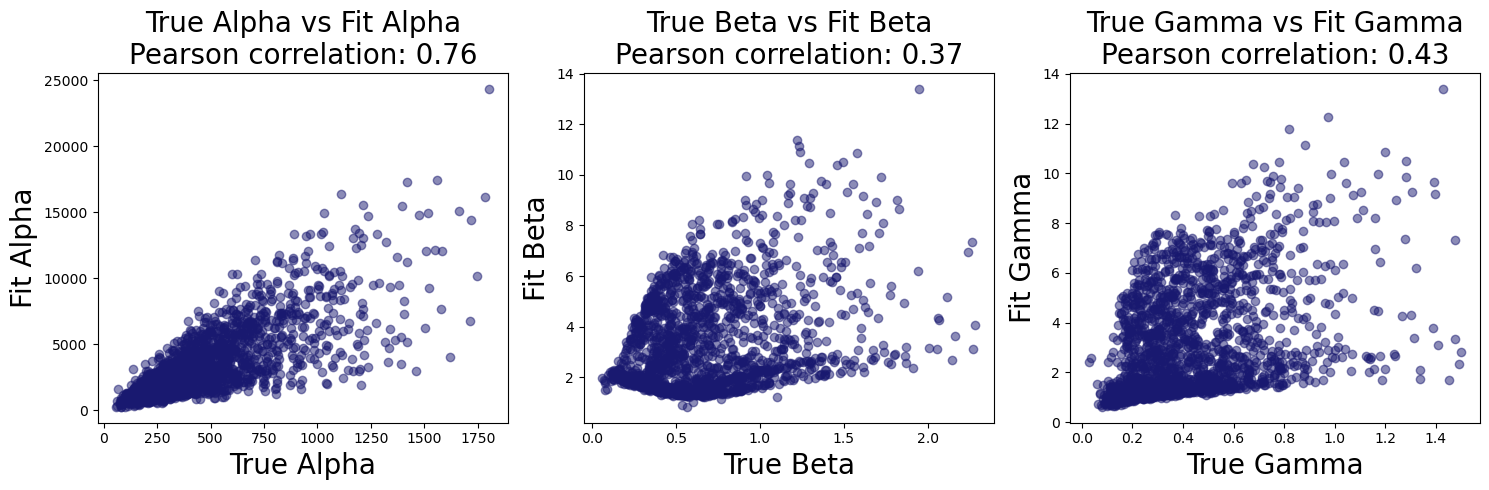

In [12]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats

# Assuming adata object is already defined with the following keys
true_alpha_values = adata.var['true_alpha']
fit_alpha_values = adata.var['vae_alpha']
true_beta_values = adata.var['true_beta']
fit_beta_values = adata.var['vae_beta']
true_gamma_values = adata.var['true_gamma']
fit_gamma_values = adata.var['vae_gamma']

# Calculate Pearson correlation coefficients
corr_alpha, _ = scipy.stats.pearsonr(true_alpha_values, fit_alpha_values)
corr_beta, _ = scipy.stats.pearsonr(true_beta_values, fit_beta_values)
corr_gamma, _ = scipy.stats.pearsonr(true_gamma_values, fit_gamma_values)

# Create subplots
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

# Plot the correlations with scatter plots and show Pearson correlation coefficients
axes[0].scatter(true_alpha_values, fit_alpha_values, color='midnightblue', alpha=0.5)
axes[0].set_xlabel('True Alpha', fontsize=20)
axes[0].set_ylabel('Fit Alpha', fontsize=20)
axes[0].set_title(f'True Alpha vs Fit Alpha\nPearson correlation: {corr_alpha:.2f}',fontsize=20)

axes[1].scatter(true_beta_values, fit_beta_values, color='midnightblue', alpha=0.5)
axes[1].set_xlabel('True Beta', fontsize=20)
axes[1].set_ylabel('Fit Beta', fontsize=20)
axes[1].set_title(f'True Beta vs Fit Beta\nPearson correlation: {corr_beta:.2f}',fontsize=20)

axes[2].scatter(true_gamma_values, fit_gamma_values, color='midnightblue', alpha=0.5)
axes[2].set_xlabel('True Gamma', fontsize=20)
axes[2].set_ylabel('Fit Gamma', fontsize=20)
axes[2].set_title(f'True Gamma vs Fit Gamma\nPearson correlation: {corr_gamma:.2f}',fontsize=20)

plt.tight_layout()

# Save the figure to a file
plt.savefig('simu_vae_plots.png', dpi=300)

# Display the plots
plt.show()
